In [1]:
import matplotlib
matplotlib.use("nbagg")

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import dlc_bci as bci
from utility import * 

## Get Data
Fetches the data from the server and saves it to a folder at the root 

In [3]:
train_input, train_target, test_input, test_target = import100HzData()
train_input_1000, train_target_1000, test_input_1000, test_target_1000 = import1000HzData()

<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])
<class 'torch.FloatTensor'> torch.Size([316, 28, 500])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 500])
<class 'torch.LongTensor'> torch.Size([100])


In [4]:
print(train_input.shape) 
print(train_target.shape) 
print(test_input.shape) 
print(test_target.shape) 

torch.Size([316, 28, 50])
torch.Size([316])
torch.Size([100, 28, 50])
torch.Size([100])


## Visualize the data

In [5]:
#rawDataForSingleElectrodeVisualization(train_input)

# Preprocessing

Noise removed - Trend Removed - Offset translated - Normalized 

### A "0" Labelled signal - Without Preprocessing

<IPython.core.display.Javascript object>


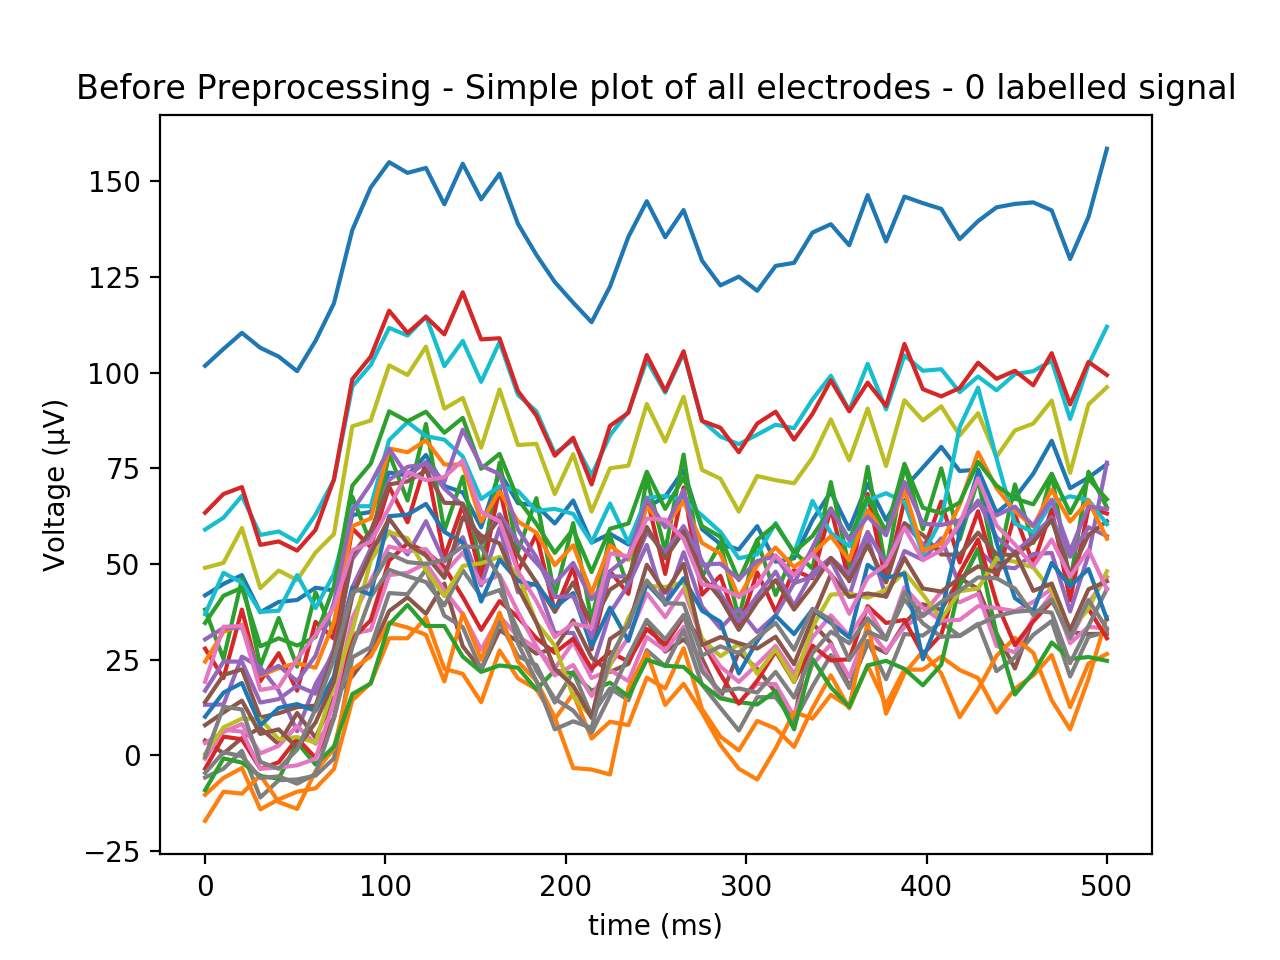

<IPython.core.display.Javascript object>


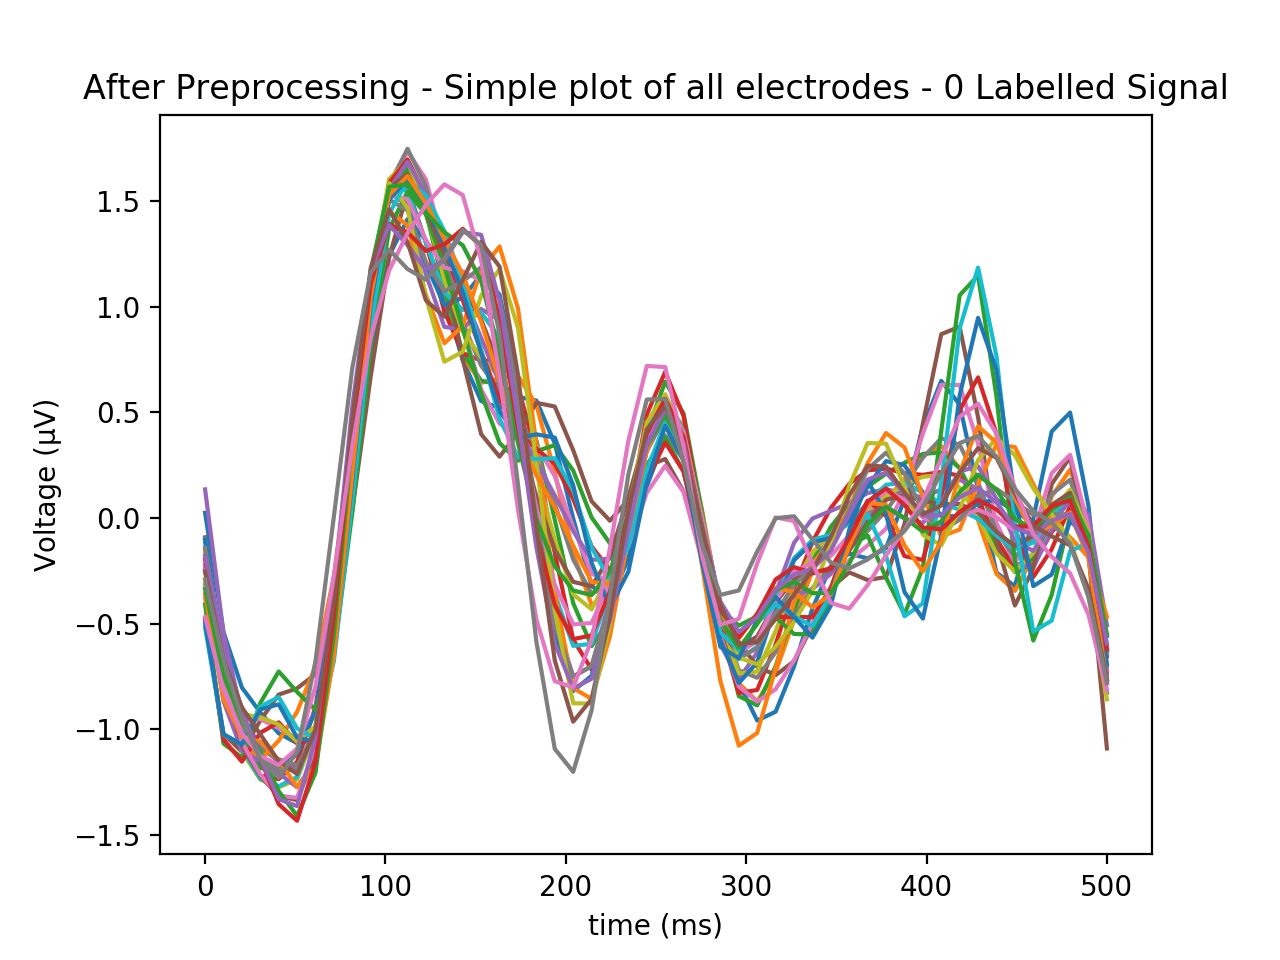

In [10]:
time = np.linspace(0, 500, 50)

rawDataVisualization(train_input, 0, 'Before Preprocessing - Simple plot of all electrodes - 0 labelled signal')
normalizedSingleSignals(train_input, time, 0, True, 'After Preprocessing - Simple plot of all electrodes - 0 Labelled Signal'); 

### A "1" Labelled signal 

<IPython.core.display.Javascript object>


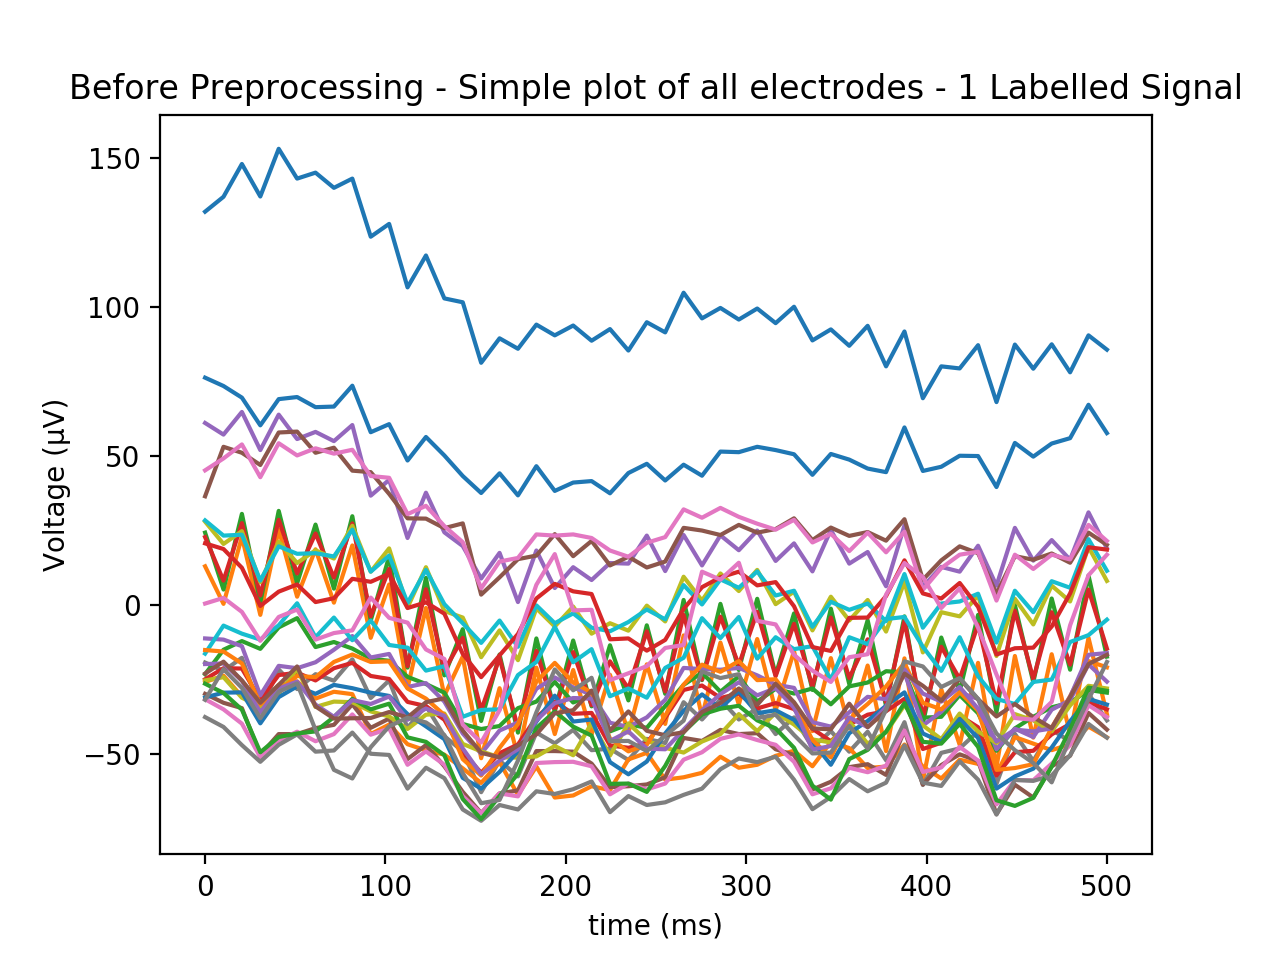

<IPython.core.display.Javascript object>


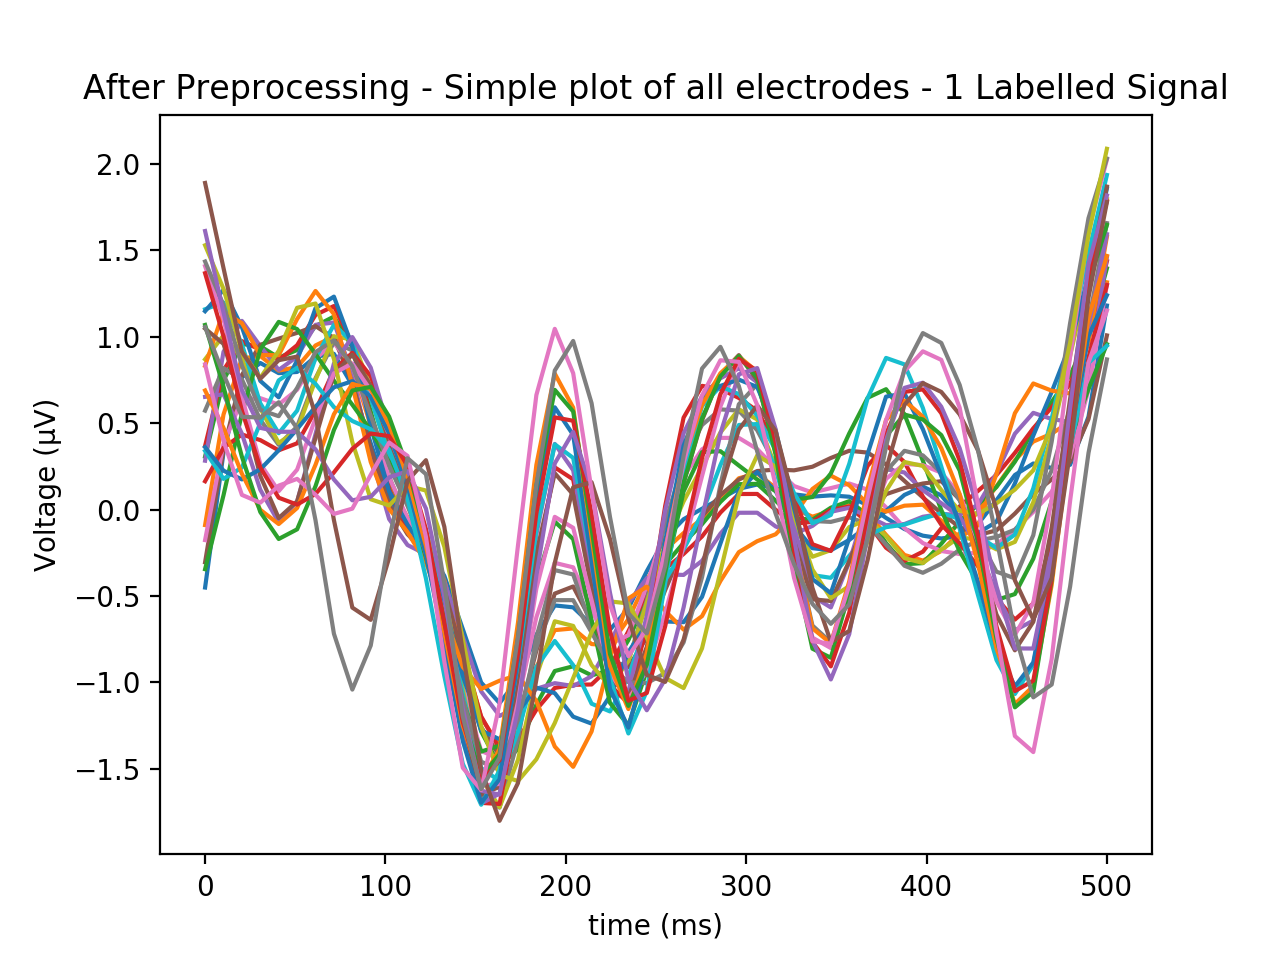

In [11]:
time = np.linspace(0, 500, 50)

rawDataVisualization(train_input, 1, 'Before Preprocessing - Simple plot of all electrodes - 1 Labelled Signal')
normalizedSingleSignals(train_input, time, 1, True, 'After Preprocessing - Simple plot of all electrodes - 1 Labelled Signal'); 

# Visualize some Normalized signals 

<IPython.core.display.Javascript object>


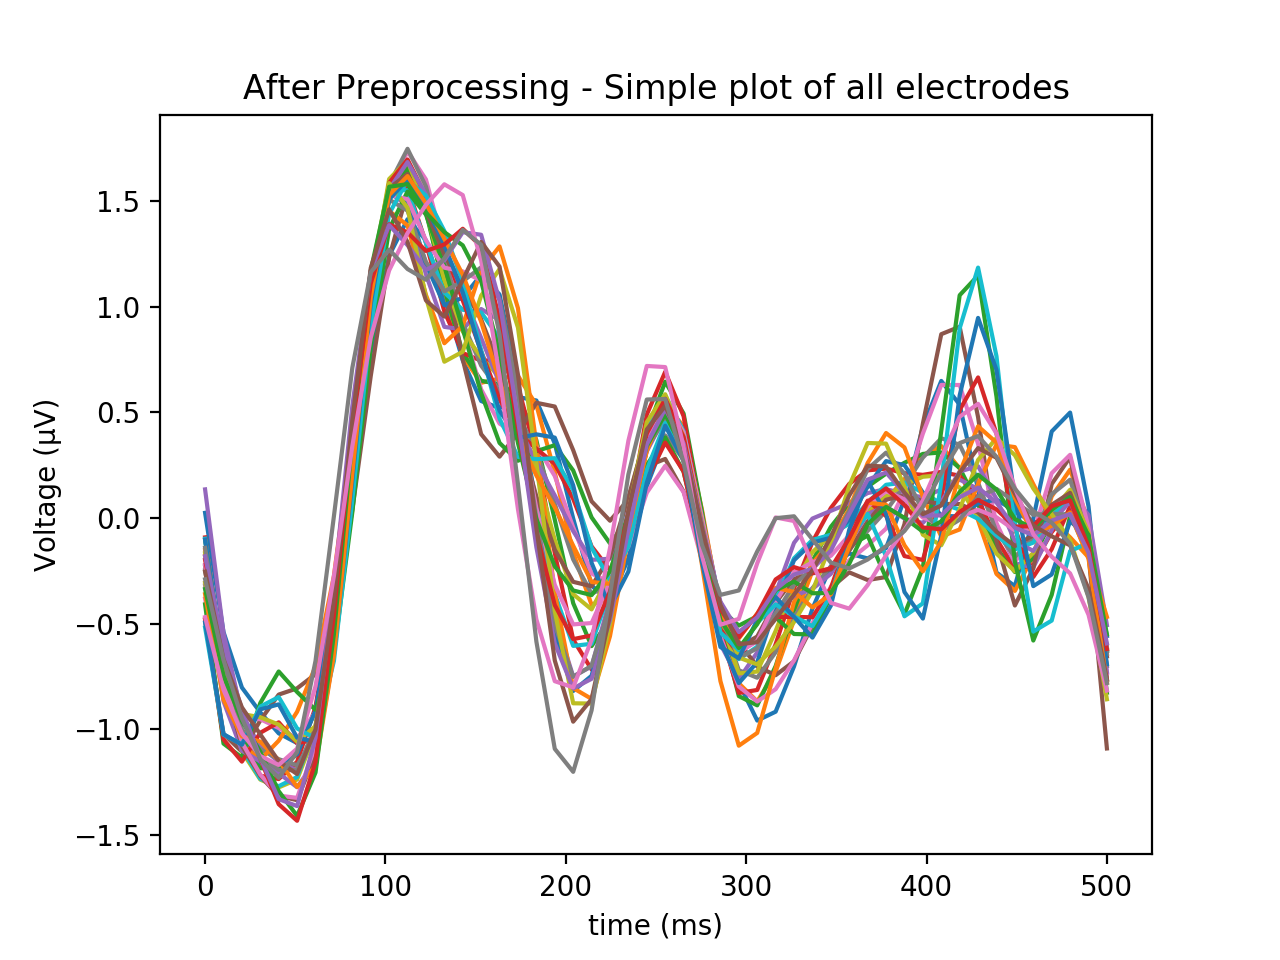

<IPython.core.display.Javascript object>


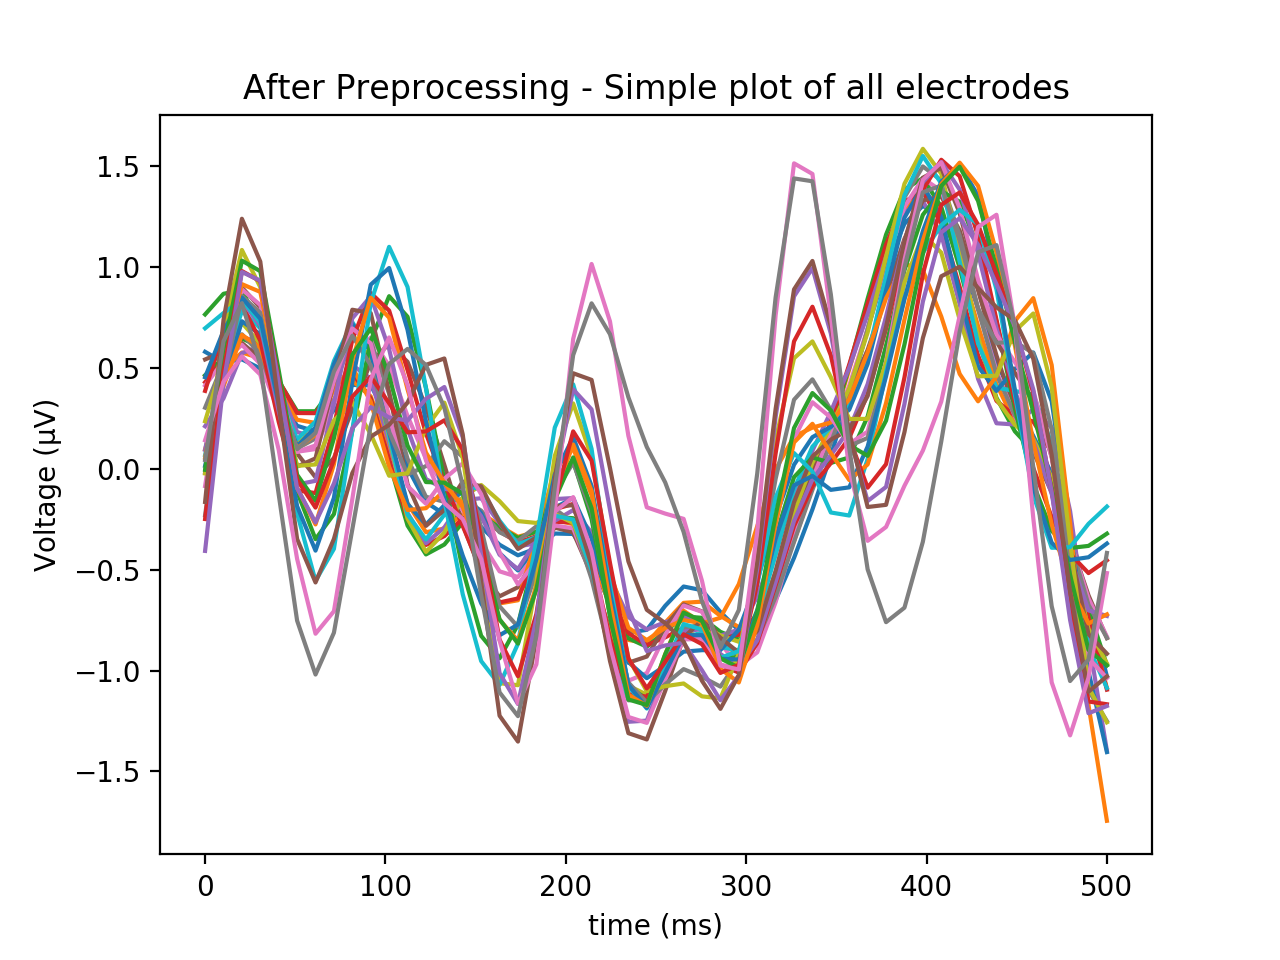

<IPython.core.display.Javascript object>


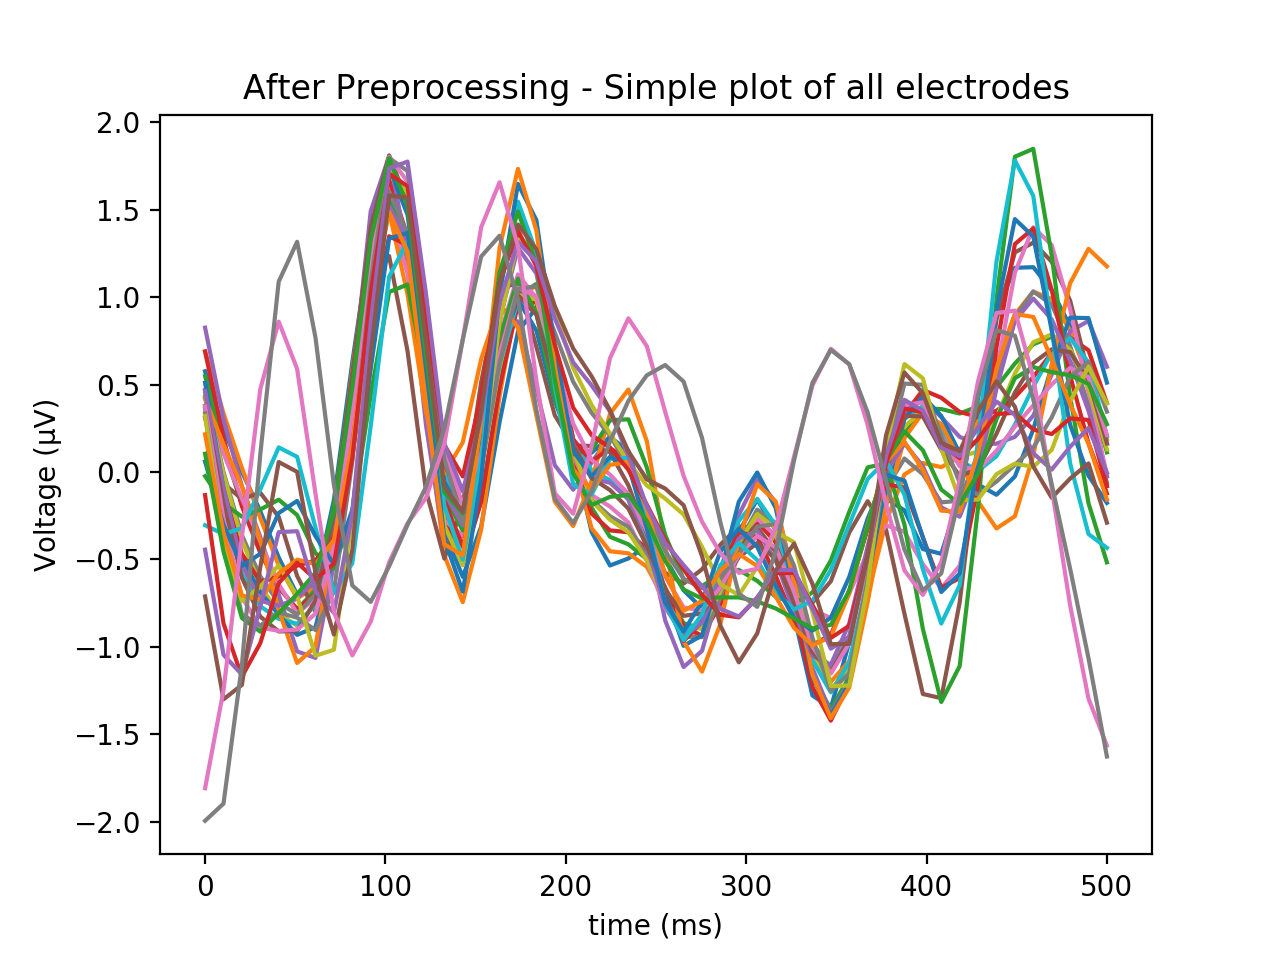

<IPython.core.display.Javascript object>


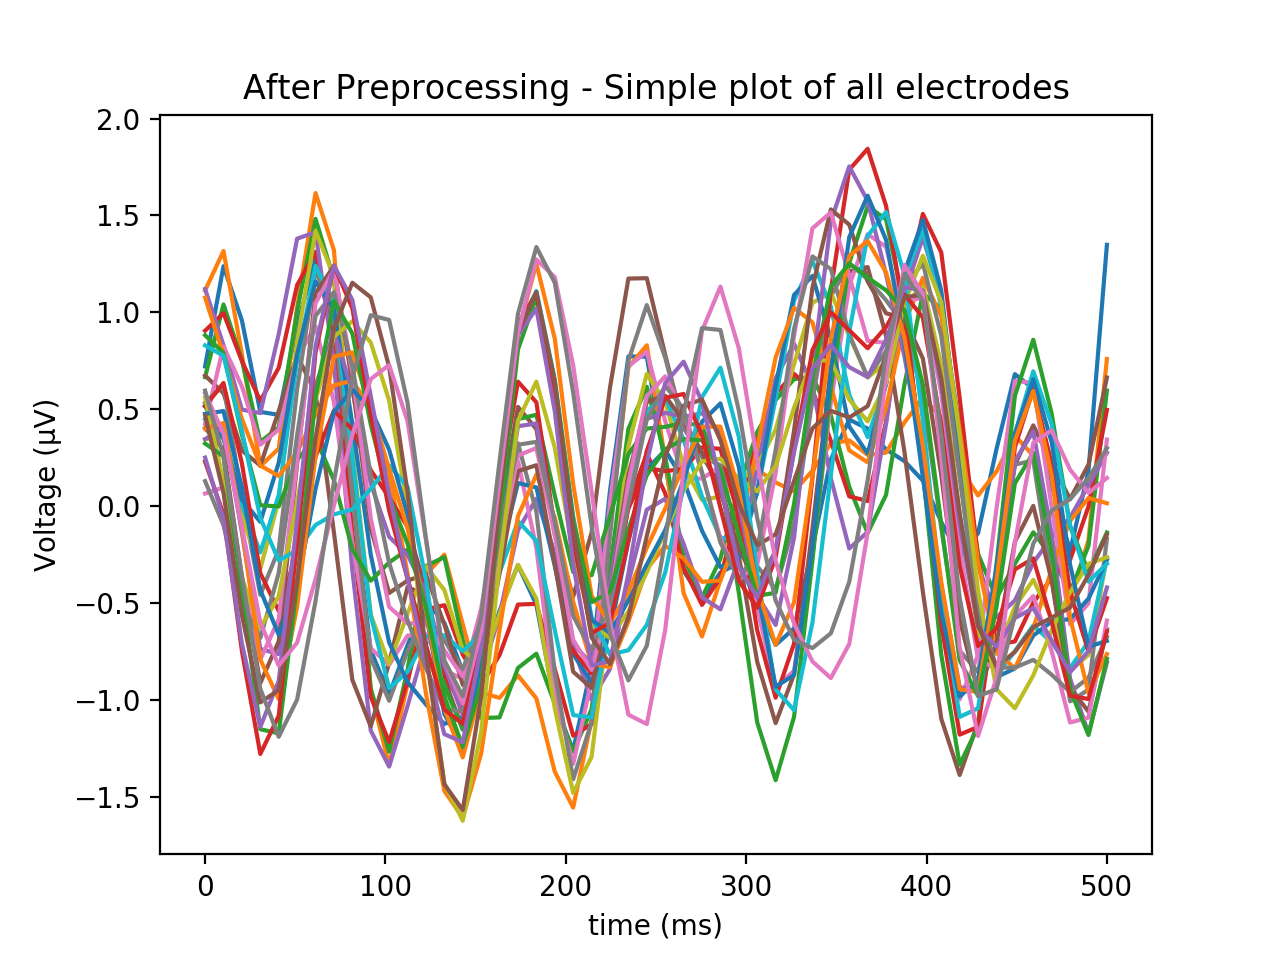

In [12]:
time = np.linspace(0, 500, 50)
normalized_input = normalizedSignals(train_input, time, True, 'After Preprocessing - Simple plot of all electrodes')

# Neural Net

In [ ]:
# Copy the neural network from the Neural Networks section before and modify it to take 18-channel signal (instead of 1-channel images as it was defined).

2. Define a Convolution Neural Network

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (1,5)) #nn.Conv2d(nbChannels, outputChannels, kxk Square convolution)
        self.pool = nn.MaxPool2d(1, 1)
        self.conv2 = nn.Conv2d(6, 16, (1,5))
        self.fc1 = nn.Linear(16 * 28 * 42, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) #2 output channel one for the left direction and one for the rightweb

    def forward(self, x):
        print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        print(x.shape)
        x = x.view(-1, 16 * 28 * 42)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
for epoch in range(30):  # loop over the dataset multiple times
    print ("\nEpoch ", epoch)
    running_loss = 0.0
   
    inputs = train_input #x_train
    inputs = torch.unsqueeze(inputs,1) # make it float and insert a fake batch dimension
    labels = train_target #y_train

    # wrap them in Variable
    inputs, labels = Variable(inputs), Variable(labels)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
 
    optimizer.step()

    running_loss += loss.data[0]
    print("Running loss", running_loss)
    
    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]

5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

# Test Dataset - Prediction 

In [ ]:
correct = 0
total = 0

prediction = test_input #x_train
prediction_squeezed = torch.unsqueeze(prediction,1) # make it float and insert a fake batch dimension
labels = test_target #y_train

# wrap them in Variable
predictionVar, labelsVar = Variable(prediction_squeezed), Variable(labels)

# forward + backward + optimize
#The outputs are energies for the 10 classes. Higher the energy for a class, the more the network thinks
#that the image is of the particular class. So, let’s get the index of the highest energy:
outputsPred = net(predictionVar) 

_, predicted = torch.max(outputsPred.data, 1) #predicted contains the predicted labels 
total += labels.size(0)
correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [ ]:
learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Variable of input data to the Module and it produces
    # a Variable of output data.
    prediction = test_input #x_train
    prediction_squeezed = torch.unsqueeze(prediction,1) # make it float and insert a fake batch dimension
    labels = test_target #y_train

    # wrap them in Variable
    predictionVar, labelsVar = Variable(prediction_squeezed), Variable(labels)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputsPred = net(predictionVar)

    # Compute and print loss. We pass Variables containing the predicted and true
    # values of y, and the loss function returns a Variable containing the
    # loss.
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(outputsPred, labelsVar)
    print(t, loss.data[0])

    # Zero the gradients before running the backward pass.
    net.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Variables with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Variable, so
    # we can access its data and gradients like we did before.
    for param in net.parameters():
        param.data -= learning_rate * param.grad.data